### Anomaly Detection by Prediction Deviation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from models import LSTM, auto_arima_pred
from data import AnomalyDatasetByConcat, EEGDataset, normalize, stackplot
from dynaconf import settings
from progress.bar import ChargingBar
import numpy as np
import matplotlib.pyplot as plt
import statistics
from metrics import get_pred_diffs, get_features_1c, mse
import seaborn as sns
import pandas as pd

In [3]:
select_channels, length, n_predictions = settings.SELECT_CHANNELS, settings.LENGTH, settings.N_PREDICTIONS
batch_size=16
use_cuda = torch.cuda.is_available()

In [7]:
# length = 500

lstm model

In [7]:
# models/saved_models/lstm_gen_v1.pt"model.load_state_dict(torch.load(
model_filename = "models/saved_models/lstm_gen_v1.1.pt"
model = LSTM(n_predictions=n_predictions, hidden_layer_size=20, num_layers=2)
# model = LSTM(n_predictions=n_predictions)
model.load_state_dict(torch.load(model_filename))
model.eval()
if use_cuda:
    model.cuda()

nn model

In [8]:
train_dataset_csv = settings.TRAIN_DATASET_CSV
dev_dataset_csv = settings.DEV_DATASET_CSV

In [17]:
length = length//2

In [68]:
train_dataset_csv = settings.TRAIN_DATASET_CSV
dev_dataset_csv = settings.DEV_DATASET_CSV

train_dataset = EEGDataset(train_dataset_csv, length, select_channels, max_num_examples=10, transform=normalize)
dev_dataset = EEGDataset(dev_dataset_csv, length, select_channels, max_num_examples=10, transform=normalize)

Found 2765 recordings
By set limit only using 10 recordings
Removing recordings of insufficient length...
Removed 0 of 10 recordings. There are now 10 recordings.
Found 345 recordings
By set limit only using 10 recordings
Removing recordings of insufficient length...
Removed 0 of 10 recordings. There are now 10 recordings.


Process ForkPoolWorker-359:
Process ForkPoolWorker-340:
Process ForkPoolWorker-344:
Process ForkPoolWorker-337:
Process ForkPoolWorker-356:
Process ForkPoolWorker-345:
Process ForkPoolWorker-347:
Process ForkPoolWorker-346:
Process ForkPoolWorker-341:
Process ForkPoolWorker-355:
Process ForkPoolWorker-358:
Process ForkPoolWorker-351:
Process ForkPoolWorker-343:
Process ForkPoolWorker-342:
Process ForkPoolWorker-349:
Process ForkPoolWorker-339:
Process ForkPoolWorker-353:
Process ForkPoolWorker-350:
Process ForkPoolWorker-357:
Process ForkPoolWorker-348:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-338:
Process ForkPoolWorker-354:
Process ForkPoolWorker-352:
Traceback (most recent call last):
Proces

In [69]:
first_recording_length = length - n_predictions
second_recording_length = n_predictions

In [71]:
train_dataset_anomaly = AnomalyDatasetByConcat(
    first_recording_length,
    second_recording_length,
    train_dataset_csv,
    length,
    select_channels,
    max_num_examples=10,
    transform=normalize
)

dev_dataset_anomaly = AnomalyDatasetByConcat(
    first_recording_length,
    second_recording_length,
    dev_dataset_csv,
    length,
    select_channels,
    max_num_examples=10,
    transform=normalize
)

Found 2765 recordings
By set limit only using 10 recordings
Removing recordings of insufficient length...
Removed 0 of 10 recordings. There are now 10 recordings.
Found 345 recordings
By set limit only using 10 recordings
Removing recordings of insufficient length...
Removed 0 of 10 recordings. There are now 10 recordings.


Process ForkPoolWorker-390:
Process ForkPoolWorker-393:
Process ForkPoolWorker-386:
Process ForkPoolWorker-400:
Process ForkPoolWorker-388:
Process ForkPoolWorker-406:
Process ForkPoolWorker-403:
Process ForkPoolWorker-395:
Process ForkPoolWorker-391:
Process ForkPoolWorker-407:
Process ForkPoolWorker-387:
Process ForkPoolWorker-404:
Process ForkPoolWorker-396:
Process ForkPoolWorker-397:
Process ForkPoolWorker-402:
Process ForkPoolWorker-405:
Process ForkPoolWorker-399:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-408:
Process ForkPoolWorker-394:
Process ForkPoolWorker-385:
Process ForkPoolWorker-389:
Process ForkPoolWorker-401:
Process ForkPoolWorker-392:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File

#### Visualize Anomaly Set

In [21]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

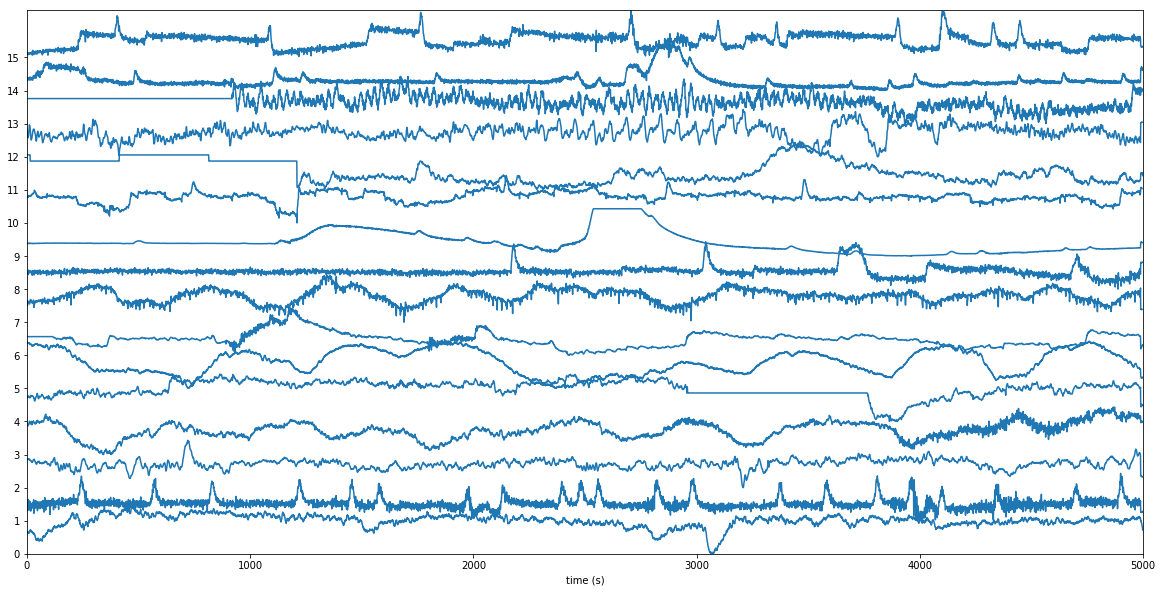

In [22]:
samples = np.asarray([train_dataset_anomaly[i].squeeze().numpy() for i in range(16)])
stackplot(samples)

### Comparison of Plain Diff

In [23]:
control_diffs = get_pred_diffs(model, train_dataset, mse)

In [24]:
print(f"mean {statistics.mean(control_diffs)}, median {statistics.median(control_diffs)}")

mean 0.022774252617952642, median 0.007801620289683342


In [12]:
# plt.hist(control_diffs, bins=40, range=(0, 3))
# print()

In [25]:
anomaly_diffs = get_pred_diffs(model, train_dataset_anomaly, mse)

In [26]:
print(f"mean {statistics.mean(anomaly_diffs)}, median {statistics.median(anomaly_diffs)}")

mean 0.3199151281363856, median 0.09226369112730026


In [15]:
# plt.hist(anomaly_diffs, bins=40, range=(0, 3))
# print()

In [28]:
# assert(len(control_diffs) == len(anomaly_diffs))

In [29]:
control_diffs = [["MSE", x, "No"] for x in control_diffs]
anomaly_diffs = [["MSE", x, "Yes"] for x in anomaly_diffs]

In [30]:
errors = pd.DataFrame.from_records(control_diffs + anomaly_diffs, columns=["Feature", "Error", "Has Anomaly"])

[]

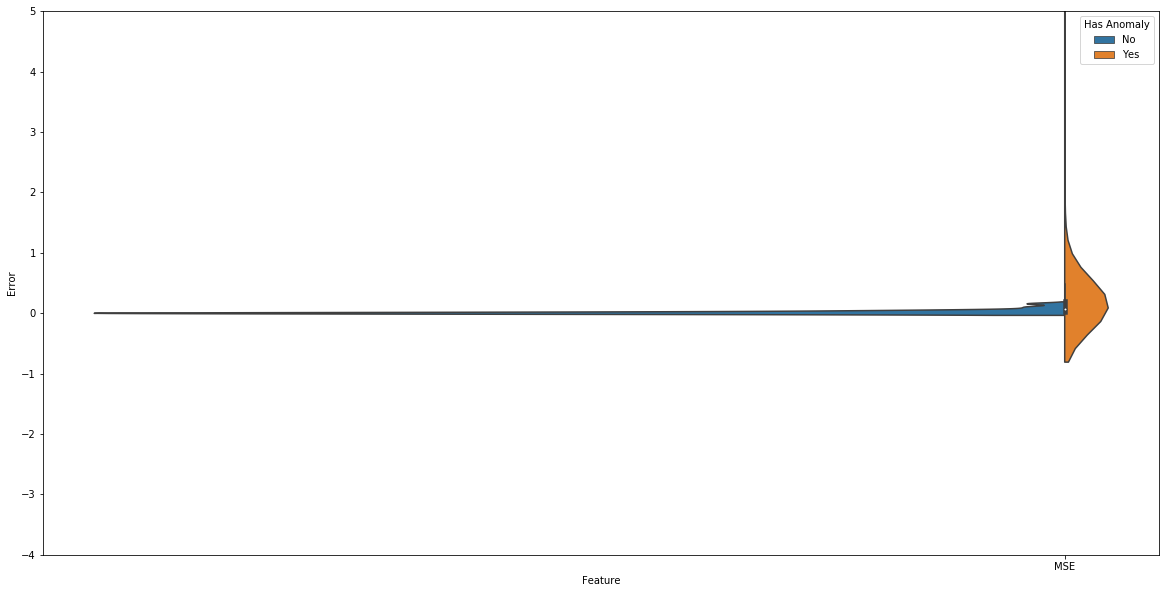

In [31]:
ax = sns.violinplot(data=errors, x="Feature", y="Error", hue="Has Anomaly", split=True)
ax.set(ylim=(-4, 5))
ax.plot()

### Add MNE Features

In [32]:
from metrics import MNEFeatureCriterion

In [33]:
def remove_nans(x):
    return [value for value in x if str(value) != 'nan']

In [34]:
def get_feature_diffs(feature_name, model, dataset, anomaly_dataset):
    
    selected_features = [feature_name]
    mne_feautres_criterion = MNEFeatureCriterion(selected_features)
    mne_feautres_criterion_func = mne_feautres_criterion.get_features_diff
    
    control_diffs = get_pred_diffs(model, dataset, mne_feautres_criterion_func)
    anomaly_diffs = get_pred_diffs(model, anomaly_dataset, mne_feautres_criterion_func)
    
    control_diffs, anomaly_diffs = remove_nans(control_diffs), remove_nans(anomaly_diffs)
    
#     control_sum = sum(abs(x) for x in control_diffs)
#     anomaly_sum = sum(abs(x) for x in anomaly_diffs)
    
#     combined_sum = control_sum + anomaly_sum
    
#     control_diffs = [2*x/combined_sum for x in control_diffs]
#     anomaly_diffs = [2*x/combined_sum for x in anomaly_diffs]
    
    print(f"Control Diffs mean {statistics.mean(control_diffs)}, median {statistics.median(control_diffs)}")
    print(f"Anomaly Diffs mean {statistics.mean(anomaly_diffs)}, median {statistics.median(anomaly_diffs)}")
    
    return control_diffs, anomaly_diffs

def add_feature_to_errors(errors, feature_name, model, dataset, anomaly_dataset):
    control_diffs, anomaly_diffs = get_feature_diffs(feature_name, model, dataset, anomaly_dataset)
    
    control_diffs = [[feature_name, x, "No"] for x in control_diffs]
    anomaly_diffs = [[feature_name, x, "Yes"] for x in anomaly_diffs]
    
    return errors.append(pd.DataFrame(anomaly_diffs + control_diffs, columns=errors.columns))

In [35]:
errors.head(5)

,Feature,Error,Has Anomaly
0,MSE,0.003916,No
1,MSE,0.006567,No
2,MSE,0.006184,No
3,MSE,0.003040,No
4,MSE,0.001889,No


In [36]:
errors_with_mne_features = errors.copy()

['app_entropy', 'decorr_time', 'energy_freq_bands', 'higuchi_fd', 'hjorth_complexity', 'hjorth_complexity_spect', 'hjorth_mobility', 'hjorth_mobility_spect', 'hurst_exp', 'katz_fd', 'kurtosis', 'line_length', 'mean', 'pow_freq_bands', 'ptp_amp', 'samp_entropy', 'skewness', 'spect_edge_freq', 'spect_entropy', 'spect_slope', 'std', 'svd_entropy', 'svd_fisher_info', 'teager_kaiser_energy', 'variance', 'wavelet_coef_energy', 'zero_crossings', 'max_cross_corr', 'nonlin_interdep', 'phase_lock_val', 'spect_corr', 'time_corr']

In [37]:
selected_features = ['app_entropy', 'decorr_time', 'line_length', 'mean', 'variance', 'kurtosis']
for feature in selected_features:
    print("Working on", feature)
    errors_with_mne_features = add_feature_to_errors(errors_with_mne_features, feature, model, train_dataset, train_dataset_anomaly)

Working on app_entropy
Control Diffs mean 1.2698356262295034, median 1.3077664871914887
Anomaly Diffs mean 1.3111599745397056, median 1.3077664871914887
Working on decorr_time


/mnt/home2/clee/code/mne_learn/mne-features/mne_features/univariate.py:60: RuntimeWarning: invalid value encountered in true_divide
  return acf[:(lags + 1)] / acf[0]
/mnt/home2/clee/code/mne_learn/mne-features/mne_features/univariate.py:60: RuntimeWarning: invalid value encountered in true_divide
  return acf[:(lags + 1)] / acf[0]
/mnt/home2/clee/code/mne_learn/mne-features/mne_features/univariate.py:60: RuntimeWarning: invalid value encountered in true_divide
  return acf[:(lags + 1)] / acf[0]
/mnt/home2/clee/code/mne_learn/mne-features/mne_features/univariate.py:60: RuntimeWarning: invalid value encountered in true_divide
  return acf[:(lags + 1)] / acf[0]
/mnt/home2/clee/code/mne_learn/mne-features/mne_features/univariate.py:60: RuntimeWarning: invalid value encountered in true_divide
  return acf[:(lags + 1)] / acf[0]
/mnt/home2/clee/code/mne_learn/mne-features/mne_features/univariate.py:60: RuntimeWarning: invalid value encountered in true_divide
  return acf[:(lags + 1)] / acf[0

Control Diffs mean 0.5102040816326531, median 0.5
Anomaly Diffs mean 0.4762396694214876, median 0.5
Working on line_length
Control Diffs mean 1.5849115206736464, median 0.6713229119777679
Anomaly Diffs mean 1.7355872420132283, median 0.6971924901008606
Working on mean
Control Diffs mean 1.3960350108884123, median 0.22699663788080215
Anomaly Diffs mean 2.29245421024735, median 1.2923932075500488
Working on variance
Control Diffs mean 9.889720259758178, median 0.9056722819805145
Anomaly Diffs mean 15236584890.820232, median 0.8823504745960236
Working on kurtosis
Control Diffs mean 0.48957113423907406, median 0.38761554658412933
Anomaly Diffs mean 0.4385395396918382, median 0.32226626574993134


In [39]:
errors.describe()

,Error
count,582.000000
mean,0.269881
std,1.277504
min,0.000315
25%,0.013467
50%,0.062914
75%,0.201034
max,20.575727


[]

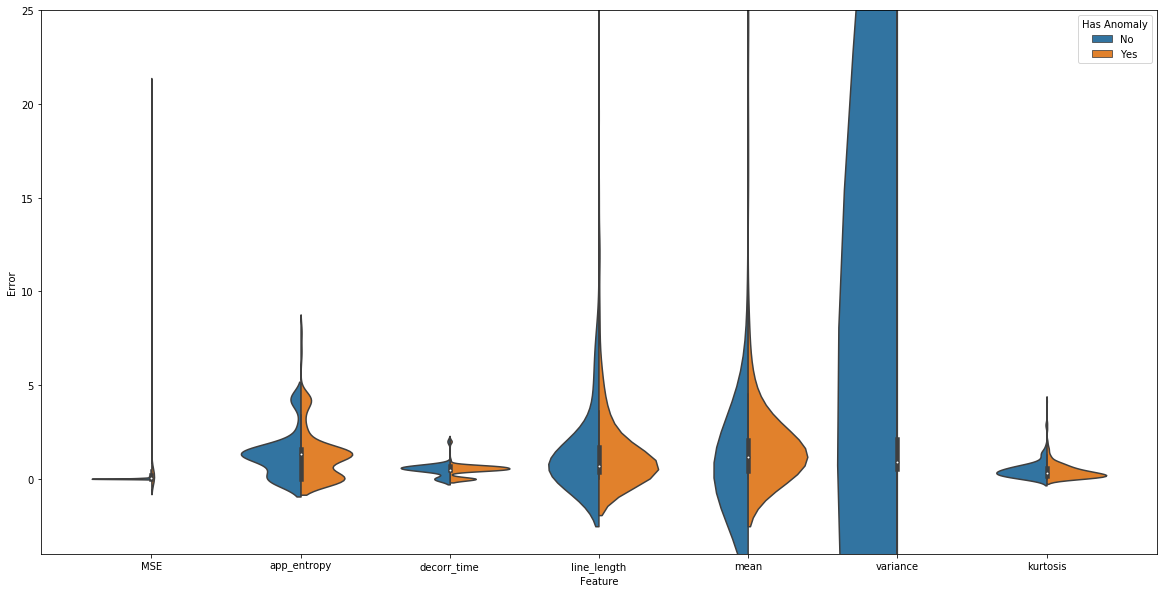

In [40]:
ax = sns.violinplot(data=errors_with_mne_features, x="Feature", y="Error", hue="Has Anomaly", split=True)
ax.set(ylim=(-4, 25))
ax.plot()

prediction of 20 time points

look at Temple siezure for anomaly set

add sliding window

### Looking at KL Divergance 

$$
$$

In [42]:
def kl_div(p, q):
#     return np.sum(p * np.log(p/q))
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [43]:
def get_kl_div_by_feature(errors, feature_name, avg_values_per_bin=15):    
    feature_errors = errors[errors.Feature == feature_name]
    feature_errors_no_anomaly =  feature_errors[feature_errors["Has Anomaly"] == "No"]
    feature_errors_anomaly = feature_errors[feature_errors["Has Anomaly"] == "Yes"]
    
    feature_errors_no_anomaly = feature_errors_no_anomaly["Error"].values
    feature_errors_anomaly = feature_errors_anomaly["Error"].values
    
    assert(len(feature_errors_no_anomaly) > 0 and len(feature_errors_anomaly) > 0)
    
    num_bins = min(len(feature_errors_no_anomaly), len(feature_errors_anomaly)) // avg_values_per_bin
    print(f"Making {num_bins} bins")
    min_val = int(min(feature_errors_no_anomaly.min(), feature_errors_anomaly.min()))
    max_val = int(max(feature_errors_no_anomaly.max(), feature_errors_anomaly.max()) + 1) # plus 1 for floor rounding 
    bin_interval = (max_val - min_val) /  num_bins   
    bins = [i*bin_interval for i in range(num_bins)]
#     bins = list(range(min_val, max_val + bin_interval, bin_interval))
    
    feature_errors_no_anomaly_hist,_ = np.histogram(feature_errors_no_anomaly, bins=bins, range=(min_val, max_val))
    feature_errors_anomaly_hist,_ = np.histogram(feature_errors_anomaly, bins=bins, range=(min_val, max_val))
    
    
    return kl_div(feature_errors_no_anomaly_hist, feature_errors_anomaly_hist)
    

In [44]:
get_kl_div_by_feature(errors_with_mne_features, "MSE")

Making 6 bins


/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


-155.29503887444665

In [45]:
get_kl_div_by_feature(errors_with_mne_features, "decorr_time")

Making 6 bins


/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


-155.145398387972

In [46]:
kl_divs = [get_kl_div_by_feature(errors_with_mne_features, feature) for feature in (selected_features + ["MSE"])]

Making 6 bins
Making 6 bins
Making 6 bins
Making 6 bins
Making 6 bins
Making 6 bins
Making 6 bins


/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
kl_divs = list(zip(selected_features, kl_divs))


In [48]:
kl_divs

[('app_entropy', -154.15158072422363),
 ('decorr_time', -155.145398387972),
 ('line_length', inf),
 ('mean', -153.27427020476438),
 ('variance', -156.11171026724278),
 ('kurtosis', -156.21321600182227)]

In [49]:
pd.DataFrame.from_records(kl_divs, columns=["Feature", "KL Div"])

,Feature,KL Div
0,app_entropy,-154.151581
1,decorr_time,-155.145398
2,line_length,inf
3,mean,-153.274270
4,variance,-156.111710
5,kurtosis,-156.213216


### Anomaly Detection with PMDArima

In [73]:
def pmdarima_model(x):
    x = x.cpu().numpy()
    pred = auto_arima_pred(x, n_preds=n_predictions, input_window_size=100)
    return torch.from_numpy(pred).cuda().float()

In [74]:
arima_control_diffs = get_pred_diffs(pmdarima_model, train_dataset, mse)

In [77]:
print(f"mean {statistics.mean(arima_control_diffs)}, median {statistics.median(arima_control_diffs)}")

mean 0.0018842586470782408, median 0.0011654917616397142


In [80]:
arima_anomaly_diffs = get_pred_diffs(pmdarima_model, train_dataset_anomaly, mse)

In [81]:
print(f"mean {statistics.mean(anomaly_diffs)}, median {statistics.median(anomaly_diffs)}")

mean 0.08611163583118468, median 0.037861214485019445


### Very Simple Decision Tree

In [83]:
from metrics import get_pred_diff

#### with pmdarima model

In [104]:
x_normal = [[get_pred_diff(pmdarima_model, x, mse).item()] for x in train_dataset]

In [105]:
x_anomaly = [[get_pred_diff(pmdarima_model, x, mse).item()] for x in train_dataset_anomaly]

In [106]:
y_normal = [0 for i in range(len(train_dataset))]
y_anomaly = [1 for i in range(len(train_dataset_anomaly))]

In [110]:
x = x_normal + x_anomaly
y = y_normal + y_anomaly

In [122]:
# for eval
x_normal_eval = [[get_pred_diff(pmdarima_model, x, mse).item()] for x in dev_dataset]
x_anomaly_eval = [[get_pred_diff(pmdarima_model, x, mse).item()] for x in dev_dataset_anomaly]
y_normal_eval = [0 for i in range(len(dev_dataset))]
y_anomaly_eval = [1 for i in range(len(dev_dataset_anomaly))]
x_eval = x_normal_eval + x_anomaly_eval
y_eval = y_normal_eval + y_anomaly_eval
combined_eval = list(zip(x_eval, y_eval))
random.shuffle(combined_eval)
x_eval, y_eval = zip(*combined_eval)
x_eval = np.asarray(x_eval)
y_eval = np.asarray(y_eval)

/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/site-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


In [112]:
import random

In [113]:
combined = list(zip(x, y))
random.shuffle(combined)
x, y = zip(*combined)

In [114]:
x = np.asarray(x)
y = np.asarray(y)

In [115]:
print("x.shape", x.shape)
print("y.shape", y.shape)

x.shape (20, 1)
y.shape (20,)


In [117]:
from sklearn.tree import DecisionTreeClassifier

In [118]:
clf = DecisionTreeClassifier()

In [119]:
clf.fit(x, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [123]:
clf.score(x_eval, y_eval)

0.85

In [131]:
clf.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

#### with LSTM model

In [127]:
# for eval data
x_normal_eval = [[get_pred_diff(model, x, mse).item()] for x in dev_dataset]
x_anomaly_eval = [[get_pred_diff(model, x, mse).item()] for x in dev_dataset_anomaly]
y_normal_eval = [0 for i in range(len(dev_dataset))]
y_anomaly_eval = [1 for i in range(len(dev_dataset_anomaly))]
x_eval = x_normal_eval + x_anomaly_eval
y_eval = y_normal_eval + y_anomaly_eval
combined_eval = list(zip(x_eval, y_eval))
random.shuffle(combined_eval)
x_eval, y_eval = zip(*combined_eval)
x_eval = np.asarray(x_eval)
y_eval = np.asarray(y_eval)

# for train data
x_normal_train = [[get_pred_diff(model, x, mse).item()] for x in train_dataset]
x_anomaly_train = [[get_pred_diff(model, x, mse).item()] for x in train_dataset_anomaly]
y_normal_train = [0 for i in range(len(train_dataset))]
y_anomaly_train = [1 for i in range(len(train_dataset_anomaly))]
x_train = x_normal_train + x_anomaly_train
y_train = y_normal_train + y_anomaly_train
combined_train = list(zip(x_train, y_train))
random.shuffle(combined_train)
x_train, y_train = zip(*combined_train)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [128]:
clf_lstm = DecisionTreeClassifier()

In [129]:
clf_lstm.fit(x, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [130]:
clf_lstm.score(x_eval, y_eval)

0.75

plot mistakes

try plotting lstm and arima on the same plot

and repeat last value